# Homework 6 - Permutation-based Variable Importance (PVI)

The goal of this notebook is to explain the feature importance of models trained on the wine quality dataset using Permutation-based Variable Importance (PVI).


We analyze the feature importance of Random Forest with default parameters in Parts 1 and 3, and additionaly a shallow Random Forest with max_depth=2, XGBoost with default hyperparameters and logistic regression in Part 2.

### 1. Permutation-based Variable Importance for Random Forest

In this section, we calculate Permutation-based Variable Importance for the Random Forest model with default hyperparameters.

<div>
<img src="images/vip_forest.png"> </img>
</div>
</br>

The plot indicates that `free sulfur dioxide` is the most significant predictor for the model. `Volatile acidity` and `total sulfur dioxide` are also important variables but to a lesser extent. Discarding the remaining variables results in a negligible drop in performance.

###  2. PVI for different models

In this part, we compare VPIs of Random Forest with default parameters with shallow Random Forest with max_depth=2, XGBoost with default hyperparameters and logistic regression.

We observe that the PVI rankings from the four models indicate varying levels of dependency on the features to make predictions. 
There is, however, a visible pattern regarding the most important features, with `free sulfur dioxide`, `volatile acidity`, and `alcohol` generally ranking high across the models.

The shallow Random Forest model exhibits a higher drop-out loss across the features when compared to the full Random Forest, indicating a higher dependency on the included features. This could be due to the reduced complexity of the model, making it more sensitive to the permutation of its variables.

The XGBoost model demonstrates a more balanced distribution of feature importance, with less extreme drop-out loss values. This indicates that while it considers `free sulfur dioxide` important, it does not rely as heavily on any single feature as the Random Forest models do. 

The Logistic Regression model, being a linear model, shows the most distinct variable importance ranks, with `volatile acidity` being the most important feature. This model has several features with a PVI of zero, which may be due to its inability to capture non-linear relationships between variables.

<div>
<img src="images/vip_forest_shallow.png"> </img>
</div></br>

<div>
<img src="images/vip_xgboost.png"> </img>
</div></br>

<div>
<img src="images/vip_logistic_reg.png"> </img>
</div></br>

### 3. PVI vs gini vs shap

In this section, for the Random Forest model, we compare different feature importance metrics:

- PVI (dropout_loss): This metric indicates how much the model's performance decreases when a feature's information is shuffled. This method directly measures the impact of the feature on the model's accuracy.
- Gini impurity: This is an internal metric used by the Random Forest algorithm during the construction of the trees. It measures how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.
- SHAP: SHAP values are a game theory-based approach that assigns each feature an importance value for a particular prediction.

<div>
<img src="images/metrics.png"> </img>
</div></br>

Comparing these metrics:
- All three metrics agree on the most important features, with `free sulfur dioxide`, `volatile acidity`, and `total sulfur dioxide` consistently appearing as key variables.
- `Free sulfur dioxide` consistently shows the highest importance across all metrics, which might indicate its strong and direct relationship with the target variable.
- The differences in the magnitude of importance across the three metrics for the same features could be due to their different calculations. PVI assesses the impact on model performance, Gini impurity reflects the feature's usefulness in creating pure leaves during model training, and SHAP values provide insight into the impact on the prediction outcome for individual instances.

- The relative rankings among less important features vary across the metrics, which could imply different interpretations of feature contributions depending on the metric used.

## Appendix

#### 0. Import packages

In [135]:
import dalex as dx

import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (5,3)

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


### Train a tree-based ensemble model

#### 0.1 Load dataset

In [136]:
TARGET_COL = 'is_good'

cols = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    TARGET_COL
]

df = pd.read_csv('wine_quality.csv', header=0, names=cols)
df[TARGET_COL] = df[TARGET_COL].replace(-1, 0)
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (4898, 11)
y: (4898,)


#### 0.2 Apply SMOTE oversampling

In [137]:
print("Original class distribution:", np.bincount(y))

# Applying SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Print the new class distribution
print("New class distribution:", np.bincount(y_res))

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

Original class distribution: [4715  183]
New class distribution: [4715 4715]


#### 0.3 Fit models

In [138]:
models = {
    "Forest": RandomForestClassifier(random_state=25),
    "Forest_shallow": RandomForestClassifier(random_state=25, max_depth=2),
    "XGBClassifier": XGBClassifier(random_state=25),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=25),
}

for model in models.values():
    model.fit(X_train, y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


### 1 & 2. Calculate Permutation-based Variable Importance for different models

In [139]:
explainers = {}

def predict_func(model, df):
    return model.predict_proba(df)[:, 1]


for model_name, model in models.items():
    explainer = dx.Explainer(model, X_test, y_test, predict_function=predict_func, label=model_name)
    explainers[model_name] = explainer

Preparation of a new explainer is initiated

  -> data              : 1886 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1886 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Forest
  -> predict function  : <function predict_func at 0x135870160> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.515, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.95, mean = -0.0136, max = 0.93
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 1886 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target varia

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isin

In [140]:
pvis = [explainer.model_parts(random_state=0) for explainer in explainers.values()]

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated 

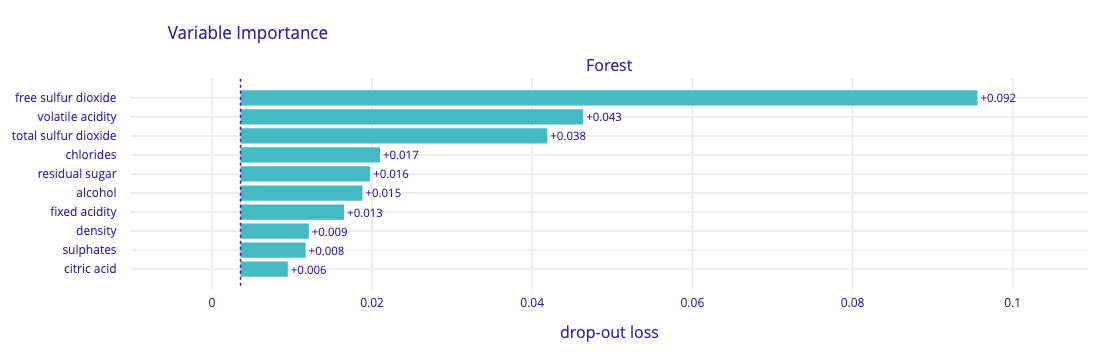

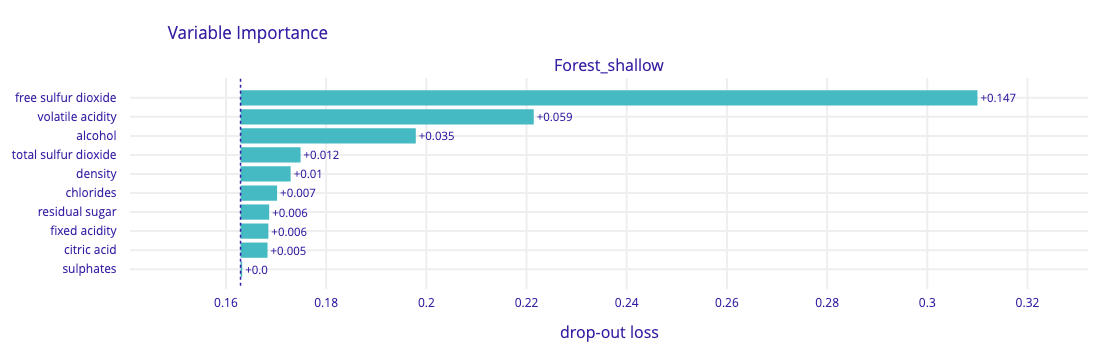

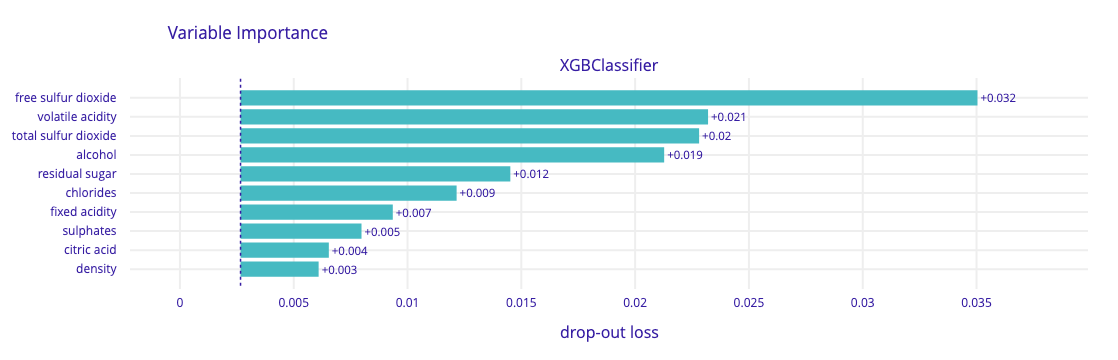

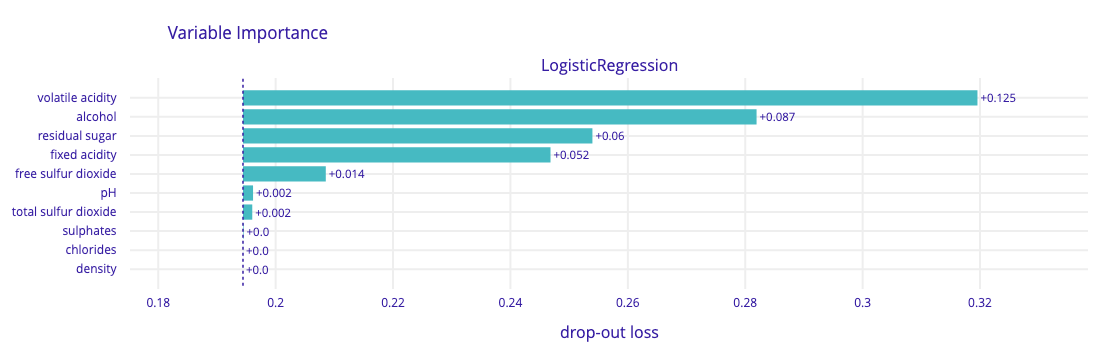

In [141]:
for model_name, pvi in zip(explainers.keys(), pvis):
    pvi.plot()

### 3. PVI vs gini vs shap

In [142]:
explainer = explainers["Forest"]
pvi = explainer.model_parts(random_state=0)
stats_df = pvi.result
full_model_loss = stats_df[stats_df['variable'] == '_full_model_']['dropout_loss'].iloc[0]
stats_df['dropout_loss'] = stats_df['dropout_loss'] - full_model_loss
stats_df = stats_df[~stats_df['variable'].isin(['_full_model_', '_baseline_'])]
stats_df = stats_df.drop(columns="label")

In [143]:
#gini
model = explainer.model
gini_values = model.feature_importances_
gini_dict = dict(zip(model.feature_names_in_, gini_values))
stats_df["gini"] = stats_df["variable"].map(gini_dict)

In [144]:
#shap
import shap
shap_explainer = shap.explainers.Tree(model, data=X_train, model_output="probability")
shap_values = shap_explainer(X_test)
shap_abs = shap_values.abs.mean(0).values[:, 1]
shap_dict = dict(zip(model.feature_names_in_, shap_abs))
stats_df["shap"] = stats_df["variable"].map(shap_dict)

 99%|===================| 3742/3772 [01:27<00:00]        

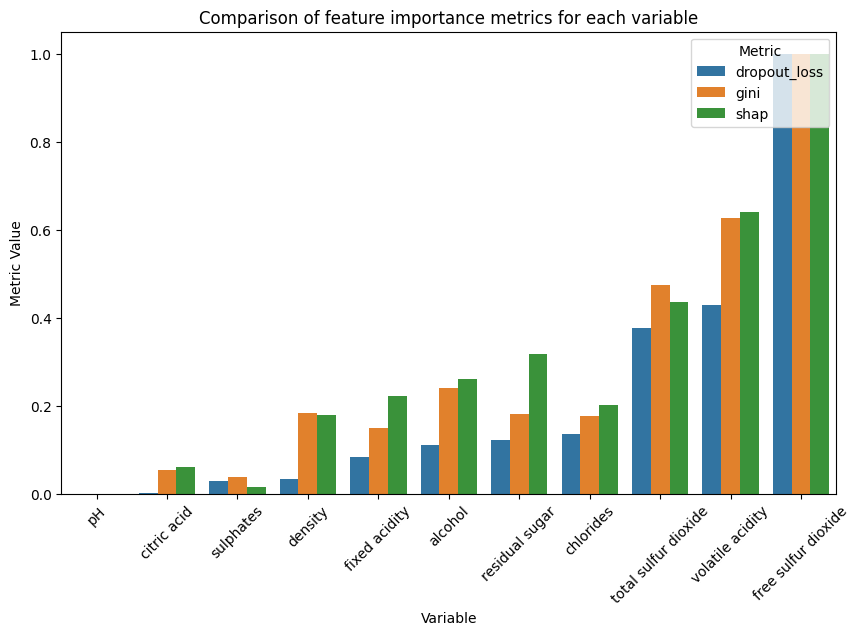

In [150]:
def normalize_df(df, columns):
    new_df = df.copy()
    for column in columns:
        min_value = new_df[column].min()
        max_value = new_df[column].max()
        new_df[column] = (df[column] - min_value) / (max_value - min_value)
    return new_df

score_vars = ['dropout_loss', 'gini', 'shap']
stats_df = normalize_df(stats_df, score_vars)
df_long = pd.melt(stats_df, id_vars=['variable'], value_vars=score_vars, var_name="score")


# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='variable', y='value', hue='score', data=df_long)
plt.title('Comparison of feature importance metrics for each variable')
plt.ylabel('Metric Value')
plt.xlabel('Variable')
plt.xticks(rotation=45)
plt.legend(title='Metric', loc='upper right')

# Show plot
plt.show()